In [28]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
from sparse_causal_model_learner_rl.trainable.gumbel_switch import WithInputSwitch, sample_from_logits_simple
gin.enter_interactive_mode()

In [29]:
class LinearModel(nn.Module):
    def __init__(self, input_shape):
        super(LinearModel, self).__init__()
        self.layer = nn.Linear(in_features=10, out_features=1, bias=True)
    def forward(self, x):
        return self.layer(x)

In [30]:
gin.bind_parameter('LearnableSwitch.switch_neg', 3)
gin.bind_parameter('LearnableSwitch.switch_pos', 0)
gin.bind_parameter('LearnableSwitch.tau', 1.0)
gin.bind_parameter('sample_from_logits_simple.tau', 1.0)
gin.bind_parameter('LearnableSwitch.sample_threshold_min', None)#0.6)
gin.bind_parameter('LearnableSwitch.sample_threshold', 1 - 1e-1)
# gin.bind_parameter('LearnableSwitch.sample_fcn', sample_from_logits_simple)
gin.bind_parameter('LearnableSwitch.sample_many', True)
gin.bind_parameter('WithInputSwitch.enable_switch', True)

In [31]:
wsw = WithInputSwitch(model_cls=LinearModel, input_shape=(10,))

In [32]:
X = torch.from_numpy(np.random.randn(5000, 10)).to(torch.float32)

In [33]:
y = X[:, 0].view(-1, 1)

In [34]:
wsw.switch(X, return_mask=True).mean()

tensor(0.0499, grad_fn=<MeanBackward0>)

In [35]:
wsw.switch.softmaxed()

tensor([0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474,
        0.0474], grad_fn=<SelectBackward>)

In [36]:
loss_obj = nn.MSELoss()

In [37]:
opt = torch.optim.Adam(wsw.parameters(), lr=1e-3)
losses = []
masks = []
grads = []
weights = []

In [38]:
# grads[-1]

In [39]:
# wsw.switch.logits.grad.data[1]

In [ ]:
for _ in tqdm(range(10000)):
    opt.zero_grad()
    loss = loss_obj(wsw(X), y)
    loss.backward()
    opt.step()

    mask = wsw.switch.softmaxed().detach().numpy()
    grad = wsw.switch.logits.grad.data[1].detach().numpy().copy()
#     print(grad)

    losses.append(loss.item())

    
    weight = wsw.model.layer.weight.detach().numpy().flatten()
    weights.append(weight)
    masks.append(mask)
    grads.append(grad)
    


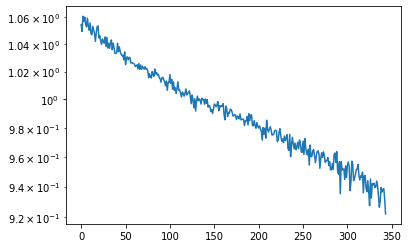

In [23]:
plt.plot(losses)
plt.yscale('log')

In [24]:
wsw.switch.softmaxed()

tensor([0.1148, 0.0374, 0.0382, 0.0718, 0.0341, 0.0686, 0.0716, 0.0395, 0.0367,
        0.0573], grad_fn=<SelectBackward>)

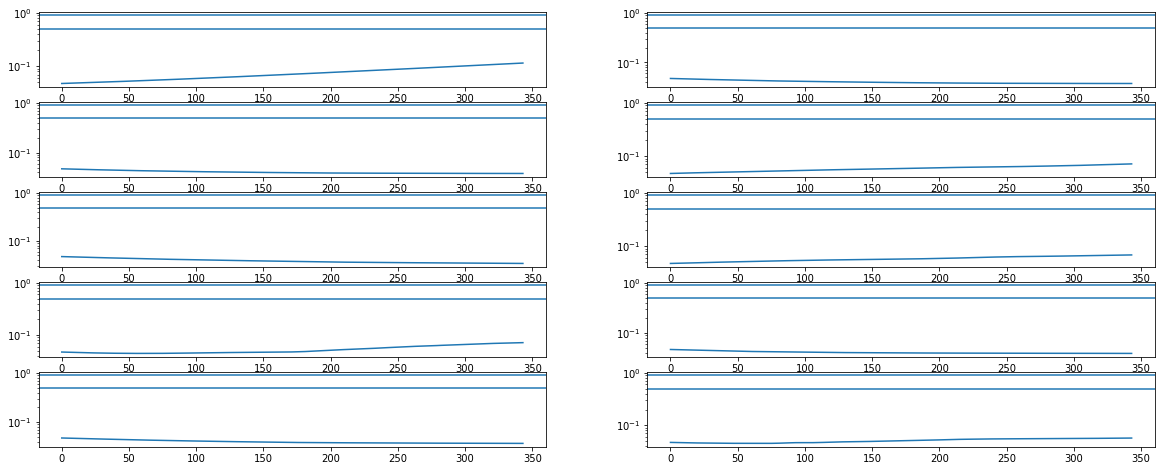

In [25]:
masks_np = np.array(masks)
px = 5
py = 2
plt.figure(figsize=(20, 8))
for i in range(masks_np.shape[1]):
    plt.subplot(px, py, i + 1)
    plt.plot(masks_np[:, i])
#     plt.ylim(, 1))
    plt.yscale('log')
    plt.axhline(0.5)
    plt.axhline(0.9)

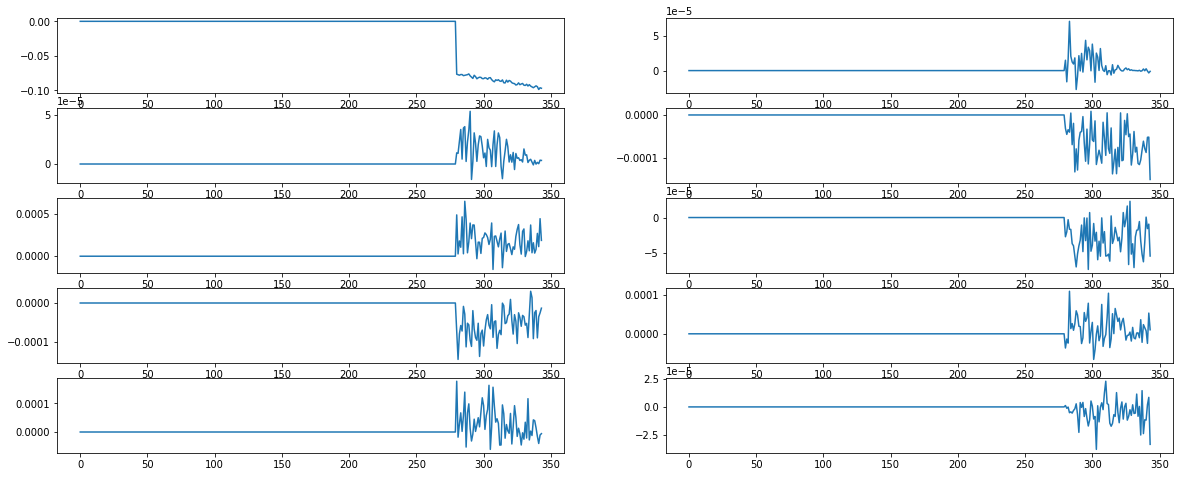

In [26]:
grads_np = np.array(grads)
px = 5
py = 2
plt.figure(figsize=(20, 8))
for i in range(grads_np.shape[1]):
    plt.subplot(px, py, i + 1)
    plt.plot(grads_np[:, i])
#     plt.ylim(, 1))
#     plt.yscale('log')
#     plt.axhline(0.5)
#     plt.axhline(1-1e-1)

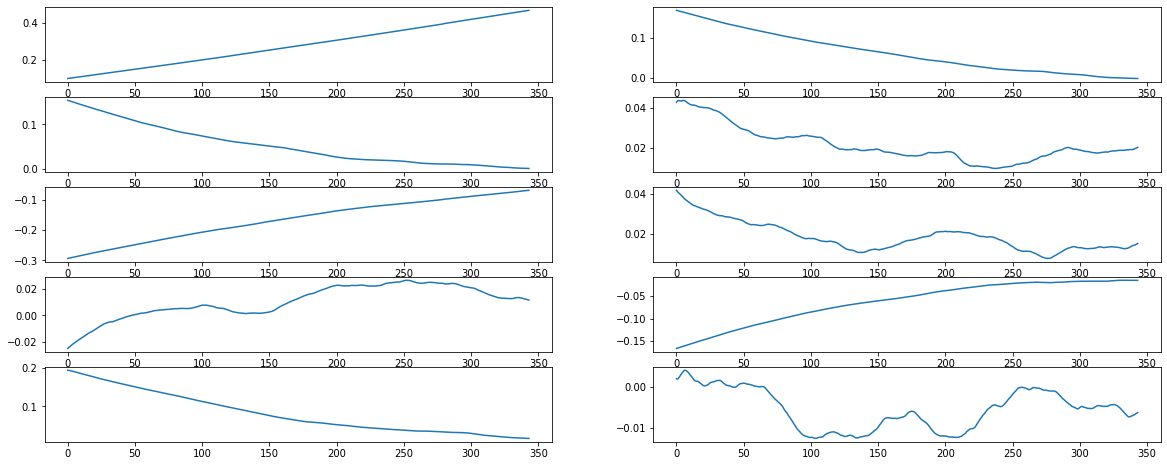

In [27]:
weights_np = np.array(weights)
px = 5
py = 2
plt.figure(figsize=(20, 8))
for i in range(weights_np.shape[1]):
    plt.subplot(px, py, i + 1)
    plt.plot(weights_np[:, i])
#     plt.ylim(, 1))
#     plt.yscale('log')
#     plt.axhline(0.5)
#     plt.axhline(1-1e-1)

In [ ]:
wsw.switch.forward(X, return_mask=True)

In [ ]:
# def sample_from_logits_simple(logits_plus):
#     probas = torch.nn.Sigmoid()(logits_plus)
#     sampled = torch.bernoulli(probas)
#     return sampled + probas - probas.detach()

In [ ]:
sample_from_logits_simple(wsw.switch.logits).mean().backward()

In [16]:
wsw.switch.logits.grad

tensor([[0.0041, 0.0125, 0.0125, 0.0125, 0.0125, 0.0124, 0.0124, 0.0125, 0.0125,
         0.0125],
        [0.0041, 0.0125, 0.0125, 0.0125, 0.0125, 0.0124, 0.0124, 0.0125, 0.0125,
         0.0125]])